In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^GSPC'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(14911, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1965-01-04,84.459999,85.150002,83.769997,84.230003,84.230003,4.433551,0.997277,1.004749,1.004749
1965-01-05,84.629997,85.019997,84.019997,84.629997,84.629997,4.438289,1.000000,1.003072,1.003072
1965-01-06,84.889999,85.379997,84.449997,84.889999,84.889999,4.441356,1.000000,1.004359,1.004359
1965-01-07,85.260002,85.620003,84.660004,85.260002,85.260002,4.445705,1.000000,1.001290,1.001290
1965-01-08,85.370003,85.839996,84.910004,85.370003,85.370003,4.446995,1.000000,1.000351,1.000351
1965-01-11,85.400002,85.809998,84.900002,85.400002,85.400002,4.447346,1.000000,1.002459,1.002459
1965-01-12,85.610001,85.980003,85.129997,85.610001,85.610001,4.449802,1.000000,1.002687,1.002687
1965-01-13,85.839996,86.269997,85.349998,85.839996,85.839996,4.452485,1.000000,1.000000,1.000000
1965-01-14,85.839996,86.379997,85.410004,85.839996,85.839996,4.452485,1.000000,1.004310,1.004310


In [3]:
SIM_START = pd.to_datetime('1983-01-04')  # first day of legit open/close values
SIM_START

Timestamp('1983-01-04 00:00:00')

In [4]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False])}

In [5]:
def tweak_best_params(params, factor=2):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    meths = ['ew', 'ma', 'linear']
    idx = meths.index(method)
    ps = np.array([1, 1, 1])
    ps[idx] = factor
    ps = ps / ps.sum()
    method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = np.random.choice([True, False])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q}

In [6]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method == 'linear':
        trend = (
            df.logval.rolling(window=40).apply(lambda x: x[-1] / x[0]))
    return trend

In [7]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [8]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [9]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.intraday_change
    return invested, reserve, invested + reserve

In [10]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    df['amt_in'] = bounded_sigmoid(
        df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [11]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total)
            plt.yscale('log')
            plt.show()
    return current_best, best_params

In [12]:
with open(PARAM_PATH, 'rb') as f:
    current_best, best_params = pickle.load(f)
current_best, best_params

(38.12704558109031,
 {'time_param': 5,
  'method': 'linear',
  't': 0.999,
  'k': 0.32654862195822637,
  'as_q': True})

In [13]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Do nothing res: 37.16999204138008
Round 1: 5.289813115031278
Round 2: 0.5540986405145586
Round 3: 0.701656714923565
Round 4: 20.94937675930583
Round 5: 1.0874703872069145
Round 6: 6.991264904787774
Round 7: 1.5516767775701048
Round 8: 0.8675968472494885
Round 9: 0.9837510128718374
Round 10: 9.548042707436155
Round 11: 1.8646859279276395
Round 12: 0.2436574417931902
Round 13: 0.09884312190207233
Round 14: 12.92770878762163
Round 15: 15.082688053575213
Round 16: 1.2012962994509297
Round 17: 37.93847839000113
Round 18: 0.9310458079702302
Round 19: 0.2413091459616145
Round 20: 1.259139712076047
Round 21: 6.112231458291664
Round 22: 1.2976561594767764
Round 23: 11.97982045000513
Round 24: 6.08450440156644
Round 25: 0.8311553624175387
Round 26: 7.962891784308139
Round 27: 1.2094323750832592
Round 28: 7.619711479110454
Round 29: 2.111500813859495
Round 30: 1.5547109351417951
Round 31: 21.864635792112946
Round 32: 36.258735996199064
Round 33: 1.4452211831017652
Round 34: 0.5367681232940263
Rou

In [14]:
best_out, params_out = run_simulation(
    df.copy(), 
    iters=100, 
    current_best=best_out, 
    best_params=params_out, 
    param_select='tweak',
    factor=4) # closer to 1: small changes; bigger: bigger

Do nothing res: 37.16999204138008
Round 1: 36.8243984959168
Round 2: 36.8243984959168
Round 3: 37.977867497944466
Round 4: 1.267263001564967
Round 5: 36.8243984959168
Round 6: 37.79367827467223
Round 7: 3.1853850266314416
Round 8: 0.6592593302547842
Round 9: 1.7653539937524885
Round 10: 1.3577085770740085
Round 11: 6.992414684123736
Round 12: 36.00643198126947
Round 13: 37.57203670030223
Round 14: 37.92884766017455
Round 15: 1.349435013790347
Round 16: 1.5763434041207212
Round 17: 37.76285085654291
Round 18: 37.91719210444461
Round 19: 36.8243984959168
Round 20: 20.181776399643713
Round 21: 0.000987677135247957
Round 22: 37.52525867303167
Round 23: 1.5675063470645894
Round 24: 10.02204890644403
Round 25: 3.5473038040778113
Round 26: 38.01276263302785
Round 27: 37.83067978068807
Round 28: 1.448114716550672
Round 29: 12.465077632092019
Round 30: 36.8243984959168
Round 31: 2.2183275694218016
Round 32: 4.449247453365233e-06
Round 33: 7.658767219045867
Round 34: 37.78776421276404
Round 35: 

In [15]:
best_out, params_out = run_simulation(
    df.copy(), 
    iters=100, 
    current_best=best_out, 
    best_params=params_out, 
    param_select='tweak',
    factor=2) # closer to 1: small changes; bigger: bigger

Do nothing res: 37.16999204138008
Round 1: 38.090521303399974
Round 2: 2.3305809835635953
Round 3: 0.3979433964808722
Round 4: 5.682799197215835
Round 5: 37.938478389349434
Round 6: 37.87512863492171
Round 7: 14.488357095935235
Round 8: 37.93836270325481
Round 9: 37.877811046831056
Round 10: 4.792604793803329
Round 11: 36.8243984959168
Round 12: 37.80099454965887
Round 13: 0.17565009399867287
Round 14: 1.9227741077442628
Round 15: 37.93374041563415
Round 16: 18.43754016468604
Round 17: 31.66671539816999
Round 18: 2.3810851530467364e-07
Round 19: 37.80310245626684
Round 20: 1.6553401582836347e-05
Round 21: 0.41525811287324743
Round 22: 37.93847838981169
Round 23: 1.4689517215217696
Round 24: 37.8688293399335
Round 25: 37.92775497138685
Round 26: 0.0006278263373962019
Round 27: 2.6247529993408856
Round 28: 0.5318007321659995
Round 29: 38.05584026583707
Round 30: 6.026293883780612
Round 31: 5.6109299857377
Round 32: 9.391124125473204e-08
Round 33: 1.1340945730985503
Round 34: 5.9654102645

In [16]:
best_out, params_out

(38.12704558109031,
 {'time_param': 5,
  'method': 'linear',
  't': 0.999,
  'k': 0.32654862195822637,
  'as_q': True})

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k
/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: overflow encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


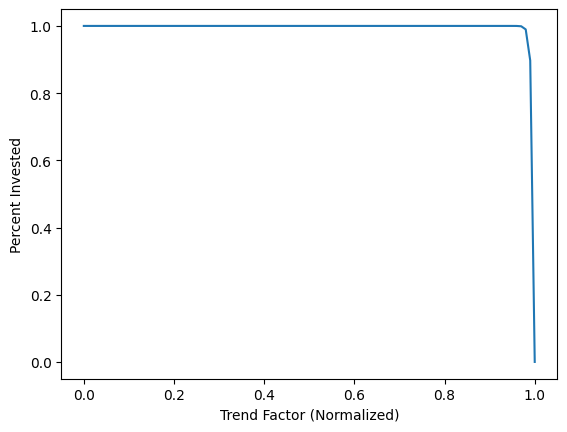

In [17]:
xs = np.linspace(0, 1, 101)
ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys);

In [18]:
df['trend_factor'] = rescale_minmax(
    get_trend_multiple(
        df.logval,
        params_out['time_param'],
        method=params_out['method'],
        as_q=params_out['as_q']))
df['amt_in'] = bounded_sigmoid(
    df.trend_factor, params_out['t'], params_out['k'], 'down')
df['amt_in'][-1]

0.0299698437274597

In [19]:
df['trend_factor'][-1]

0.9998655100531235

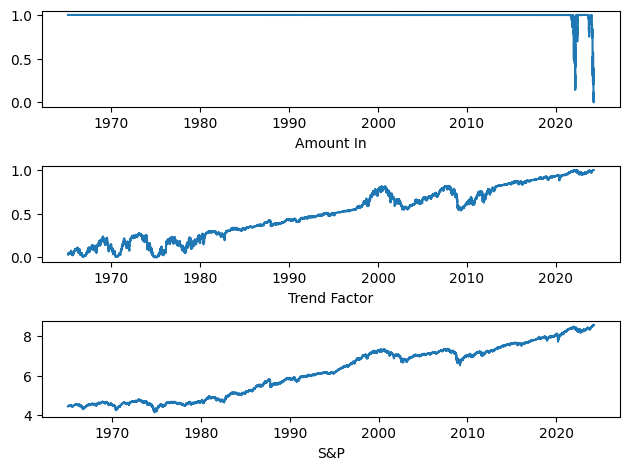

In [20]:
plt.subplot(3, 1, 1)
plt.plot(df.amt_in)
plt.xlabel('Amount In')

plt.subplot(3, 1, 2)
plt.plot(df.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(3, 1, 3)
plt.plot(df.logval)
plt.xlabel('S&P')
plt.tight_layout();

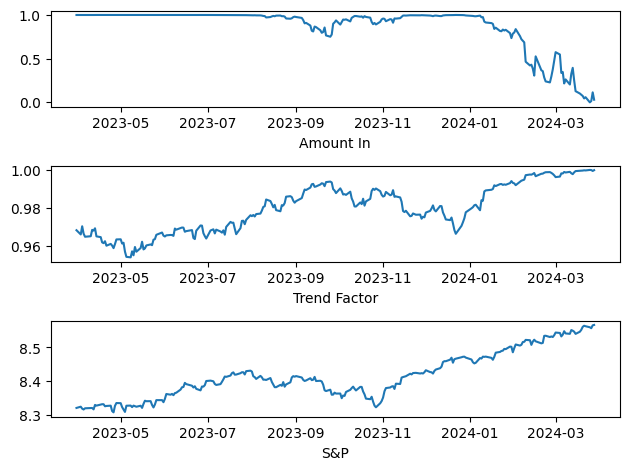

In [21]:
N = 250
plt.subplot(3, 1, 1)
plt.plot(df.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(3, 1, 2)
plt.plot(df.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(3, 1, 3)
plt.plot(df.logval[-N:])
plt.xlabel('S&P')
plt.tight_layout();

In [22]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)

In [23]:
df['amt_in'][-1]

0.0299698437274597